# Definición del proyecto de datos

Todo este proyecto tiene su base en la obtención de ciertos insights a partir de 3 bases de datos, las cuales tiene como cobertura geográfica el estado de los ángeles de estados unidos, es decir, es un proyecto donde en particular se estudiara las relaciones entre las diferentes bases de datos donde la región a estudiar son los ángeles.

- Crimen

- Negocios

- Vivienda

El contexto, es simple, trabajamos para el gobierno como alcalde de la ciudad y por tanto, las decisiones que se tomen, deberán de ser tomadas con una perspectiva meramente política, por ello es que los objetivos de este análisis deben de centrarse en la obtención de accionables claros a partir de las relaciones e interacciones encontradas en las bases de datos.

Los ángeles se dividen en 114 vecindarios, sobre los cuales se deberán de realizar el análisis, es decir, la investigación es a nivel de vecindarios. Por tanto, un punto relevante es evaluar la granularidad de la información en las bases de datos así como preguntas de la siguiente naturaleza

¿Qué vecindarios tienen una mayor tasa de muerte de negocios?, ¿se relaciona con la tasa de crimen?
¿Qué vecindarios tienen la mayor tasa de crimen?, ¿necesitan mayor atención policial?
¿Está esto afectando a los precios de las propiedades?  

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
                  
import geopandas as gpd                # Manejo de datos geoespaciales :contentReference[oaicite:8]{index=8}
from shapely.geometry import Point     # Construcción de geometrías puntuales :contentReference[oaicite:9]{index=9}

import requests
import io
from http.client import IncompleteRead

In [2]:
sns.set_style("darkgrid")
pd.options.display.float_format = "{:,.2f}".format

In [3]:
# URLs de descarga
crime_url    = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"      # Crimen 2020–Presente :contentReference[oaicite:10]{index=10}
business_url = "https://data.lacity.org/api/views/r4uk-afju/rows.csv?accessType=DOWNLOAD"     # Listado de negocios :contentReference[oaicite:11]{index=11}
zhvi_url     = "~/work/Neighborhood_zhvi.csv"                                                 # ZHVI mensual por vecindario :contentReference[oaicite:12]{index=12}
areas_url    = "https://geohub.lacity.org/datasets/691805703915458da4b35d8088f29501_0.geojson" # Área por vecindario :contentReference[oaicite:13]{index=13}
bounds_url   = "https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0.geojson" # Límites de vecindario :contentReference[oaicite:14]{index=14}
census_url   = "https://data.lacity.org/api/views/nwj3-ufba/rows.csv?accessType=DOWNLOAD"      # Censo 2010 por consejo :contentReference[oaicite:15]{index=15}


In [4]:
def fetch_csv_stream(url: str, timeout: int = 60) -> io.StringIO:
    """
    Descarga un CSV por streaming.  
    En caso de IncompleteRead, reutiliza los bytes parciales descargados.
    """
    try:
        resp = requests.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        # Leer todo el texto (posible IncompleteRead aquí)
        text = resp.text
    except IncompleteRead as e:
        # e.partial es un bytes con lo descargado antes de la excepción
        print('Incompleto:', e.partial)
        text = e.partial.decode('utf-8', errors='replace')
    return io.StringIO(text)

# Crimen

## Definición de requerimientos de datos

El primer paso para abordar el tratamiento de los datos que corresponden al crimen es comenzar por la definición de los requerimientos de datos. Este paso, se abordarán los temas relacionados con las fuentes, variables y objetivos de negocio para el análisis, estableciendo criterios de calidad y formatos esperados 

| Campo             | Descripción                                                                                                 |
|-------------------|-------------------------------------------------------------------------------------------------------------|
| **DR_NO**         | Número de expediente, formado por 2 dígitos de año + código de área + dígitos secuenciales                  |
| **Date Rptd**     | Fecha en la que se reportó el incidente al LAPD (MM/DD/YYYY)                                                |
| **DATE OCC**      | Fecha en que ocurrió el incidente (MM/DD/YYYY)                                                              |
| **TIME OCC**      | Hora de ocurrencia, en formato militar (24 h)                                                               |
| **AREA**          | Código de área (1–21) que identifica la estación comunitaria                                                |
| **AREA NAME**     | Nombre de la estación (“77th Street”, “Central”, etc.)                                                      |
| **Rpt Dist No**   | Número de distrito, subdivisión numérica dentro de cada área para análisis estadístico                       |
| **Part 1‑2**      | Indica si el delito es UCR Part I (crímenes más graves) o Part II                                            |
| **Crm Cd**        | Código de delito, código numérico principal asignado al incidente                                             |
| **Crm Cd Desc**   | Descripción textual del delito (`Crm Cd`)                                                                    |
| **MOCodes**       | Modus operandi: lista de códigos que describen comportamientos del sospechoso                                 |
| **Vict Age**      | Edad de la víctima, en años                                                                                  |
| **Vict Sex**      | Sexo de la víctima: M=Masculino, F=Femenino, X=Desconocido                                                   |
| **Vict Descent**  | Ascendencia/etnicidad de la víctima (H=Hispano, B=Negro, W=Blanco, A=Asiático, etc.)                         |
| **Premis Cd**     | Código de la ubicación (tipo de inmueble, vehículo o lugar)                                                  |
| **Premise Desc**  | Descripción de la ubicación (`Premis Cd`)                                                                    |
| **Weapon Used Cd**| Código del arma o instrumento utilizado                                                                       |
| **Weapon Desc**   | Descripción del arma (`Weapon Used Cd`)                                                                      |
| **Status**        | Estado del caso (p. ej. IC=In Commission, CA=Cleared by Arrest, etc.)                                         |
| **Status Desc**   | Descripción del código de estado (`Status`)                                                                  |
| **Crm Cd 1**      | Delito principal (más grave) del incidente                                                                   |
| **Crm Cd 2**      | Delito secundario 1 (si aplica)                                                                              |
| **Crm Cd 3**      | Delito secundario 2 (si aplica)                                                                              |
| **Crm Cd 4**      | Delito secundario 3 (si aplica)                                                                              |
| **LOCATION**      | Ubicación aproximada (número de manzana redondeado al centenar más cercano)                                  |
| **Cross Street**  | Calle transversal más cercana al punto de `LOCATION`                                                         |
| **LAT**           | Latitud en coordenadas geográficas (WGS 84) del punto del incidente                                           |
| **LON**           | Longitud en coordenadas geográficas (WGS 84) del punto del incidente                                          |


In [5]:
crime_buffer = fetch_csv_stream(crime_url)

raw_df = pd.read_csv(crime_buffer, low_memory=False) 

del crime_buffer

In [6]:
raw_df.columns = raw_df.columns.str.strip()

# Mostrar las primeras columnas para verificar nombres exactos
print(raw_df.columns.tolist())

['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005199 entries, 0 to 1005198
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1005199 non-null  int64  
 1   Date Rptd       1005199 non-null  object 
 2   DATE OCC        1005199 non-null  object 
 3   TIME OCC        1005199 non-null  int64  
 4   AREA            1005199 non-null  int64  
 5   AREA NAME       1005199 non-null  object 
 6   Rpt Dist No     1005199 non-null  int64  
 7   Part 1-2        1005199 non-null  int64  
 8   Crm Cd          1005199 non-null  int64  
 9   Crm Cd Desc     1005199 non-null  object 
 10  Mocodes         853440 non-null   object 
 11  Vict Age        1005199 non-null  int64  
 12  Vict Sex        860418 non-null   object 
 13  Vict Descent    860406 non-null   object 
 14  Premis Cd       1005183 non-null  float64
 15  Premis Desc     1004611 non-null  object 
 16  Weapon Used Cd  327282 non-null   fl

In [8]:
raw_df.head(3)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.00,998.00,NaN,NaN,1900 S LONGWOOD AV,NaN,34.04,-118.35
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.00,998.00,NaN,NaN,1000 S FLOWER ST,NaN,34.04,-118.26
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.00,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.02,-118.30


In [9]:
raw_df["Date Rptd"] = pd.to_datetime(raw_df["Date Rptd"], format="%m/%d/%Y %I:%M:%S %p", errors="raise")
raw_df["DATE OCC"] = pd.to_datetime(raw_df["DATE OCC"], format="%m/%d/%Y %I:%M:%S %p", errors="raise")

# Negocios

In [10]:
business_bufer = fetch_csv_stream(business_url)

business_df = pd.read_csv(business_bufer, low_memory=False)

del business_bufer

In [11]:
business_df.columns = business_df.columns.str.strip()

business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607924 entries, 0 to 1607923
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   LOCATION ACCOUNT #         1607924 non-null  object 
 1   BUSINESS NAME              1607924 non-null  object 
 2   DBA NAME                   246256 non-null   object 
 3   STREET ADDRESS             1607822 non-null  object 
 4   CITY                       1607814 non-null  object 
 5   ZIP CODE                   1607924 non-null  object 
 6   LOCATION DESCRIPTION       1607801 non-null  object 
 7   MAILING ADDRESS            369932 non-null   object 
 8   MAILING CITY               369944 non-null   object 
 9   MAILING ZIP CODE           369813 non-null   object 
 10  NAICS                      628889 non-null   float64
 11  PRIMARY NAICS DESCRIPTION  628889 non-null   object 
 12  COUNCIL DISTRICT           1607924 non-null  int64  
 13  LOCATION STA

In [12]:
business_df["LOCATION START DATE"] = pd.to_datetime(business_df["LOCATION START DATE"], format="%m/%d/%Y", errors='coerce')
business_df["LOCATION END DATE"] = pd.to_datetime(business_df["LOCATION END DATE"], format="%m/%d/%Y", errors='coerce')

In [13]:
business_df.head(3)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,"444,130.00",Hardware stores,0,2020-10-01,NaT,"(33.9581, -118.2926)"
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,NaN,NaN,8,2020-09-03,NaT,"(33.9597, -118.3028)"
2,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,NaN,NaN,5,2021-03-15,NaT,"(34.0594, -118.3135)"


# Inmuebles

## Definición de requerimientos de datos

Indice de valor de vivienda de Zollow (ZHVI): Esta es una medida del valor típico de la vivienda y de los cambios del mercado en una región y tip de vivienda determiados. Refleja el valor medio de las vivienda que se encuentra entre el percentil 36 - 65. Es disponible como medida suavizada y ajustada estacionalizada, así como en su versión cruda.


| Campo        | Descripción                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|| 
| **RegionID**   | Identificador numérico único de la región (vecindario).                                                        |
| **SizeRank**   | Ranking de tamaño de la región según número de viviendas o población (1 = más grande).                          |
| **RegionName** | Nombre del vecindario (e.g., “Hollywood Hills West”).                                                           |
| **RegionType** | Tipo de región: aquí siempre “neighborhood” (vecindario).                                                       |
| **StateName**  | Nombre completo del estado (e.g., “California”).                                                               |
| **State**      | Código del estado (abreviatura de dos letras, p.ej. “CA”).                                                      |
| **City**       | Nombre de la ciudad principal (aquí siempre “Los Angeles”).                                                     |
| **Metro**      | Nombre del área metropolitana (p.ej. “Los Angeles-Long Beach-Anaheim”).                                         |
| **CountyName** | Nombre del condado (p.ej. “Los Angeles County”).                                                                |
| **date**       | Fecha del dato de ZHVI, al final del mes (formato YYYY-MM-DD).                                                  |
| **price**      | Valor típico de vivienda (ZHVI) en dólares para ese mes y vecindario, suavizado y ajustado estacionalmente.     |



In [6]:
zhvi_df = pd.read_csv(zhvi_url, low_memory=False)

In [9]:
zhvi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21628 entries, 0 to 21627
Columns: 312 entries, RegionID to 2025-03-31
dtypes: float64(303), int64(2), object(7)
memory usage: 51.5+ MB


In [69]:
columns = zhvi_df.columns[:9]

zhvi_df_long = zhvi_df.melt(id_vars=columns, var_name="date", value_name="Price")

zhvi_df_long["date"] = pd.to_datetime(zhvi_df_long["date"], errors="coerce")

zhvi_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6553284 entries, 0 to 6553283
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   SizeRank    int64         
 2   RegionName  object        
 3   RegionType  object        
 4   StateName   object        
 5   State       object        
 6   City        object        
 7   Metro       object        
 8   CountyName  object        
 9   date        datetime64[ns]
 10  Price       float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 550.0+ MB


In [108]:
zhvi_df_long["year"] = zhvi_df_long["date"].dt.year
zhvi_df_long["month"] = zhvi_df_long["date"].dt.month

Ahora bien, el siguiente estudio se enfoca únicamente en los ángeles, por tanto, únicamente necesitamos acotar los resultados al estado de los ángeles. En este sentido el volumen de datos, también disminuye y esto nos beneficia a la hora de poder realizar el tratamiento de los datos

In [138]:
zhvi_df_long_ca = zhvi_df_long[zhvi_df_long["State"] == "CA"]
zhvi_df_long_ca.describe()[1:]

,RegionID,SizeRank,date,Price,Year,month,year
count,"681,144.00","681,144.00",681144,"609,516.00","681,144.00","681,144.00","681,144.00"
mean,"467,871.93","8,716.50",2012-08-30 04:35:38.613861120,"668,576.52","2,012.13",6.46,"2,012.13"
min,"3,563.00",4.00,2000-01-31 00:00:00,"28,902.89","2,000.00",1.00,"2,000.00"
25%,"268,406.75","2,758.25",2006-04-30 00:00:00,"310,728.57","2,006.00",3.00,"2,006.00"
50%,"403,192.50","6,575.00",2012-08-31 00:00:00,"513,789.14","2,012.00",6.00,"2,012.00"
75%,"763,016.25","13,675.50",2018-12-31 00:00:00,"819,372.50","2,018.00",9.00,"2,018.00"
max,"818,984.00","28,019.00",2025-03-31 00:00:00,"11,918,215.99","2,025.00",12.00,"2,025.00"
std,"265,020.73","7,141.15",NaN,"588,319.28",7.29,3.46,7.29


### Limpieza de datos

Descripción de datos

In [72]:
zhvi_df.describe()

,RegionID,SizeRank,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
count,"21,628.00","21,628.00","11,167.00","11,245.00","11,256.00","11,265.00","11,329.00","11,341.00","11,350.00","11,374.00",...,"21,628.00","21,628.00","21,627.00","21,627.00","21,627.00","21,628.00","21,628.00","21,628.00","21,627.00","21,628.00"
mean,"500,823.19","12,429.90","163,601.50","163,725.74","164,294.01","165,633.95","167,286.71","168,889.81","170,567.29","172,141.10",...,"509,628.86","509,924.35","510,148.12","510,993.44","511,925.85","512,825.63","513,622.12","513,944.54","513,859.52","513,083.71"
std,"277,616.46","7,634.96","139,816.92","140,255.63","141,142.39","143,173.40","145,436.62","147,895.02","150,474.93","152,995.14",...,"538,618.11","539,045.76","540,018.74","542,945.63","545,716.27","547,421.27","547,611.70","546,481.09","545,035.51","544,190.50"
min,"3,324.00",0.00,"3,977.87","3,946.54","3,942.66","3,942.51","3,974.80","4,037.88","4,057.95","4,084.78",...,"21,564.31","21,582.74","21,262.89","20,950.06","20,814.10","21,077.70","21,618.55","21,883.14","22,173.72","22,523.25"
25%,"270,152.75","5,682.50","83,235.72","83,073.24","83,242.73","83,595.20","84,088.89","84,526.84","84,956.27","85,519.87",...,"250,163.30","250,210.15","250,227.25","250,330.68","250,395.66","250,537.94","250,851.79","251,259.35","251,447.65","251,166.15"
50%,"416,461.50","12,084.00","127,148.46","127,244.63","127,294.27","128,064.30","129,241.95","130,111.73","130,968.06","131,814.35",...,"385,867.97","385,780.46","385,775.39","385,967.36","386,462.80","386,793.05","387,216.68","387,596.66","387,655.03","386,694.88"
75%,"806,953.25","18,940.00","191,632.85","191,670.74","192,382.87","193,795.64","195,536.81","197,215.97","199,031.09","200,531.33",...,"590,171.37","590,532.58","590,524.09","591,169.63","592,050.77","593,028.24","593,832.76","593,832.33","593,666.18","592,454.11"
max,"832,002.00","28,019.00","3,179,252.31","3,207,864.97","3,242,755.86","3,289,579.65","3,341,284.53","3,378,801.38","3,444,694.42","3,513,206.59",...,"22,007,627.60","22,072,595.38","22,222,457.28","22,479,886.64","22,726,838.94","22,769,081.20","22,648,123.80","22,441,290.97","22,196,634.23","22,128,499.72"


In [75]:
zhvi_df_long.describe()

,RegionID,SizeRank,date,Price
count,"6,553,284.00","6,553,284.00",6553284,"5,051,022.00"
mean,"500,823.19","12,429.90",2012-08-30 04:35:38.613861632,"311,828.57"
min,"3,324.00",0.00,2000-01-31 00:00:00,"3,942.51"
25%,"270,152.75","5,682.50",2006-04-30 00:00:00,"128,645.28"
50%,"416,461.50","12,084.00",2012-08-31 00:00:00,"218,120.51"
75%,"806,953.25","18,940.00",2018-12-31 00:00:00,"374,070.65"
max,"832,002.00","28,019.00",2025-03-31 00:00:00,"22,769,081.20"
std,"277,610.06","7,634.78",NaN,"351,450.40"


In [78]:
zhvi_df_long.isnull().sum()/len(zhvi_df_long)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
RegionType   0.00
StateName    0.00
State        0.00
City         0.00
Metro        0.00
CountyName   0.00
date         0.00
Price        0.23
dtype: float64

In [135]:
zhvi_df_long_ca.isnull().sum()/len(zhvi_df_long_ca)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
RegionType   0.00
StateName    0.00
State        0.00
City         0.00
Metro        0.00
CountyName   0.00
date         0.00
Price        0.11
Year         0.00
month        0.00
year         0.00
dtype: float64

In [81]:
zhvi_df_long["Price"].describe()

count    5,051,022.00
mean       311,828.57
std        351,450.40
min          3,942.51
25%        128,645.28
50%        218,120.51
75%        374,070.65
max     22,769,081.20
Name: Price, dtype: float64

Tratamiento de datos nulos

Data la baja desviación estándar que se logra apreciar esto quiere decir, que los rangos de los valores se encuentran distribuidos de forma uniforme a lo largo de los meses. Es decir, los puntos críticos para el tratamiento de datos no se encuentra en un rango mensual.

In [111]:
# Obteniendo registros de los datos faltantes
zhvi_df_long_null = zhvi_df_long[zhvi_df_long["Price"].isnull()]

# Descripción de los datos faltantes
zhvi_df_long_null["month"].value_counts().sort_index().describe()

count        12.00
mean    125,188.50
std       1,911.34
min     121,817.00
25%     124,135.50
50%     125,350.50
75%     126,281.25
max     128,932.00
Name: count, dtype: float64

Por otro lado a través de los años se logra apreciar que los datos faltantes van convergiendo a cero.

In [123]:
zhvi_df_long_null["year"].value_counts().sort_index()

year
2000    123604
2001    117141
2002    110297
2003    103386
2004     97511
2005     92133
2006     88484
2007     83843
2008     79431
2009     70370
2010     66878
2011     64351
2012     59183
2013     51173
2014     48136
2015     44252
2016     32594
2017     30464
2018     28152
2019     25808
2020     24428
2021     22862
2022     20453
2023     17324
2024         3
2025         1
Name: count, dtype: int64

In [126]:
zhvi_df_long_null["State"].value_counts().sort_index()

State
AK       736
AL     23881
AR      1301
AZ     82549
CA     71628
CO     17966
CT     11026
DC      4835
DE      6765
FL    195317
GA     56593
HI       196
IA     11898
ID      1194
IL     43018
IN     48263
KS     17998
KY      9419
LA     10593
MA      4893
MD     19929
ME      1291
MI     44024
MN      6807
MO     20442
MS     11596
MT      5565
NC     40558
ND      3906
NE     32440
NH       952
NJ     15802
NM     18881
NV     15018
NY     27097
OH     17928
OK      9864
OR      3133
PA     51337
RI       982
SC     11497
SD      3483
TN     35275
TX    384337
UT      5947
VA     60818
VT       623
WA     11807
WI     18962
WV      1892
Name: count, dtype: int64

In [30]:
zhvi_df_long["Price"].skew()

7.509058709103857

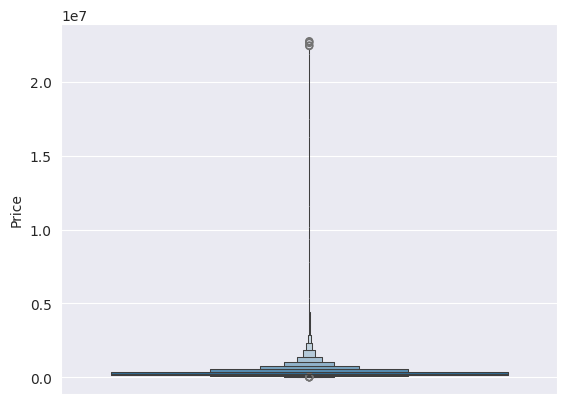

In [127]:
sns.boxenplot(zhvi_df_long["Price"])

In [ ]:
#Detección de valores atípicos
Q1 = zhvi_df_long["Price"].quantile(0.25)
Q3 = zhvi_df_long["Price"].quantile(0.75)
IQR = Q3 - Q1
zhvi_df_long_IQR = 

zhvi_df_long_clean = zhvi_df_long[~((zhvi_df_long["Price"] < (Q1 - 1.5 * IQR)) | (zhvi_df_long["Price"] > (Q3 + 1.5 * IQR)))]

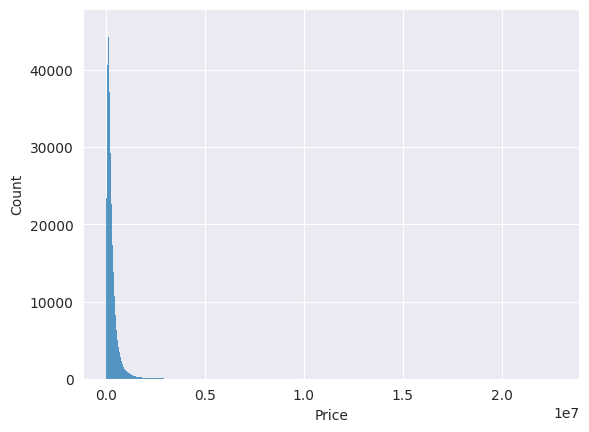

In [109]:
sns.histplot(zhvi_df_long["Price"])

plt.show()

# Descripcción 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52d42f7b-e3e4-4fa6-bf85-d2691d7edf9a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>